First, let's install the necessary libraries: `langchain` and `langgraph`.

Now, let's import the installed libraries. `langchain` is a framework for developing applications powered by large language models, and `langgraph` is an extension of LangChain for building robust and stateful multi-actor applications.

In [8]:
import langchain
import langgraph
import openai

print(f"LangChain version: {langchain.__version__}")
# LangGraph does not expose a __version__ attribute directly
# print(f"LangGraph version: {langgraph.__version__}")
print(f"OpenAI version: {openai.__version__}")

LangChain version: 1.0.8
OpenAI version: 2.8.1


Next, you'll need to set up your ChatGPT API key. If you haven't already, please add your OpenAI API key to Colab's secrets manager (the '🔑' icon in the left panel) and name it `OPENAI_API_KEY`.

In [9]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
if os.path.exists(".env"):
    load_dotenv()
    print("Environment variables loaded from .env file.")


# Access the API key
api_key = os.getenv("OPENAI_API_KEY")

if api_key:
    print("API Key loaded successfully!")
else:
    print("API Key not found. Please check your .env file.")

Environment variables loaded from .env file.
API Key loaded successfully!


# Initialization of the LLM

In [10]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

# Intialize chat model via LangChain
chat = ChatOpenAI(model="gpt-5-nano", temperature=0)
# Température 0 on prent le token qui a la probabilité la plus forte.
# Si on met une high temperature (max 1) c'est plus créatif.

messages = [
    SystemMessage(content="You're a helpful assistant for writters"),
    HumanMessage(content="What is an original topic to write about? Give me one example."),
]

print(chat.invoke(messages).content)

AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************3gEA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'code': 'invalid_api_key', 'param': None}}

# Creation of the agent state and the node "Chapter_downloader"

To extract text from the PDF, we need to install a PDF parsing library like `PyPDF2`.

<>:67: SyntaxWarning: invalid escape sequence '\P'
<>:81: SyntaxWarning: invalid escape sequence '\P'
<>:92: SyntaxWarning: invalid escape sequence '\P'
<>:117: SyntaxWarning: invalid escape sequence '\P'
<>:134: SyntaxWarning: invalid escape sequence '\P'
<>:144: SyntaxWarning: invalid escape sequence '\P'
<>:67: SyntaxWarning: invalid escape sequence '\P'
<>:81: SyntaxWarning: invalid escape sequence '\P'
<>:92: SyntaxWarning: invalid escape sequence '\P'
<>:117: SyntaxWarning: invalid escape sequence '\P'
<>:134: SyntaxWarning: invalid escape sequence '\P'
<>:144: SyntaxWarning: invalid escape sequence '\P'
C:\Users\lilid\AppData\Local\Temp\ipykernel_31484\2725039506.py:67: SyntaxWarning: invalid escape sequence '\P'
  print(f"Node 'context_downloader_node' triggered. Searching for 'Contexte.txt' in 'C:\\Documents\Pro\\11-Designing_Agentic_Systems\\Final_project\\Agentic_AI_presentation\\'.")
C:\Users\lilid\AppData\Local\Temp\ipykernel_31484\2725039506.py:81: SyntaxWarning: invalid 

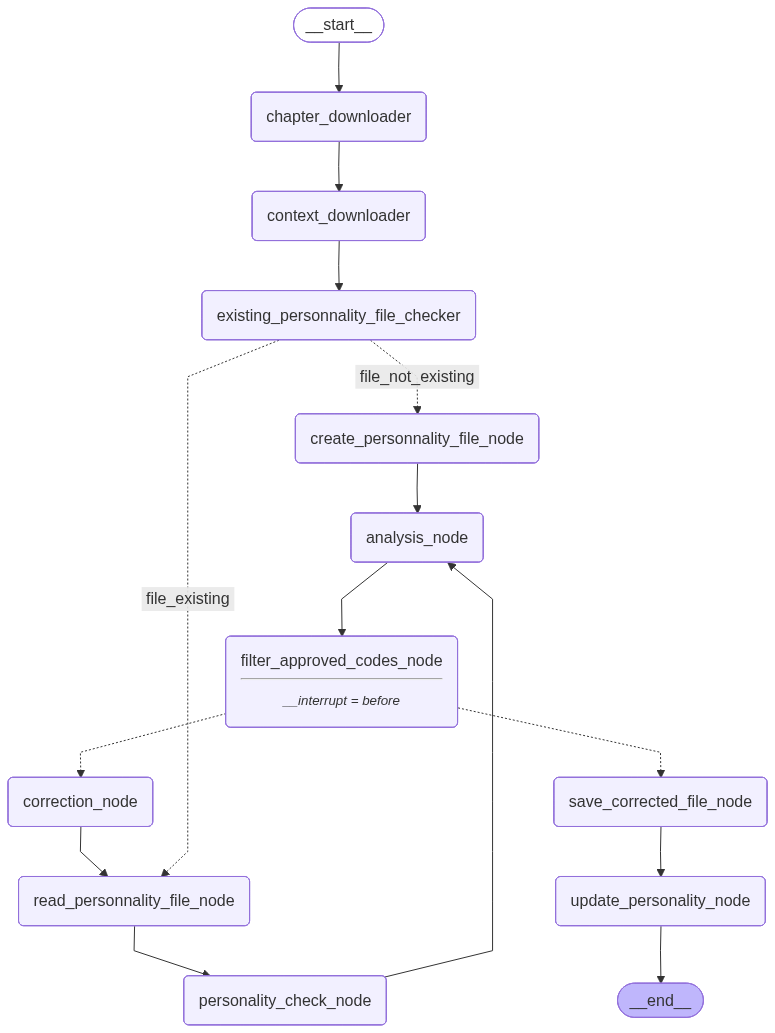

In [1]:
from typing import TypedDict, Dict, Any, List, Literal
import os
from PyPDF2 import PdfReader
import json
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display, Image
import re

# Create an AgentState to share data structure that keeps track of information as our application runs.
class AgentState(TypedDict):
    message: str # This field can now be a trigger for file search or an explicit filename.
    preview_content: str # New field to store file content confirmation or preview (first 50 chars)
    full_chapter_text: str # New field to store the entire extracted text
    source_filename: str
    context_text: str # New field to store the content of Contexte.txt
    personnality_text: str # New field to store the content of personnality.txt
    consolidated_profile: str  # The updated consolidated profile text
    personality_inconsistencies: Dict[str, Any]  # The detected P-Codes and results of the analysis
    analysis_result: Dict[str, Any] # New field to store the results of the LLM's analysis
    approved_codes: List[str] # La liste que l'utilisateur va fournir (ex: ["P1", "LA2"])
    final_filtered_report: Dict[str, Any] # Le rapport final contenant uniquement ce qui est approuvé


# This function to crate a node that's going to download the pdf with the text (named <chapter>).
def chapter_downloader_node(state: AgentState) -> AgentState:
    # Check if text is already loaded to avoid overwriting during loops
    if "full_chapter_text" not in state:
        print(f"Node 'chapter_downloader' triggered.")

        found_files = []
        for filename in os.listdir(r'C:\\Documents\Pro\\11-Designing_Agentic_Systems\\Final_project\\Agentic_AI_presentation\\'):
            if filename.lower().endswith('.pdf') and 'chapter' in filename.lower():
                found_files.append(filename)

        if found_files:
            target_filename = found_files[0]
            expected_path = os.path.join(r'C:\\Documents\Pro\\11-Designing_Agentic_Systems\\Final_project\\Agentic_AI_presentation\\', target_filename)

            # Save filename for the final update step
            state["source_filename"] = target_filename

            try:
                reader = PdfReader(expected_path)
                full_text = ""
                for page in reader.pages:
                    full_text += page.extract_text() or ""

                state["full_chapter_text"] = full_text
                state["message"] = f"Chapter loaded from {target_filename}"
                print(f"File loaded: {target_filename}")
            except Exception as e:
                state["message"] = f"Error reading PDF: {e}"
                print(f"Error reading PDF: {e}")
        else:
             # Fallback/Simulation for testing if no PDF found
            state["source_filename"] = "Chapter_Simulation.pdf"
            state["full_chapter_text"] = "John (who hates red) entered the room. He picked up a red apple and ate it with pleasure. He took out his iPhone 15 to call King Arthur."
            state["message"] = "Simulation loaded."
            print("No PDF found. Loaded simulation text.")

    return state

def context_downloader_node(state: AgentState) -> AgentState:
    print(f"Node 'context_downloader_node' triggered. Searching for 'Contexte.txt' in 'C:\\Documents\Pro\\11-Designing_Agentic_Systems\\Final_project\\Agentic_AI_presentation\\'.")

    context_filename = 'Contexte.txt'
    expected_path = os.path.join(r'C:\\Documents\Pro\\11-Designing_Agentic_Systems\\Final_project\\Agentic_AI_presentation\\', context_filename)

    try:
        with open(expected_path, 'r', encoding='utf-8') as f:
            context_content = f.read()

        state["context_text"] = context_content
        state["message"] = f"Successfully loaded '{context_filename}'. Context content stored."
        print(f"File '{context_filename}' loaded and content stored.")

    except FileNotFoundError:
        state["message"] = f"Error: '{context_filename}' not found in the 'C:\\Documents\Pro\\11-Designing_Agentic_Systems\\Final_project\\Agentic_AI_presentation\\' directory."
        state["context_text"] = ""
        print(f"Error: '{context_filename}' not found.")
    except Exception as e:
        state["message"] = f"Error reading '{context_filename}': {e}"
        state["context_text"] = ""
        print(f"Error reading '{context_filename}': {e}")

    return state

def create_personnality_file_node(state: AgentState) -> AgentState:
    print(f"Node 'create_personnality_file_node' triggered. Checking for 'personnality.txt' in 'C:\\Documents\Pro\\11-Designing_Agentic_Systems\\Final_project\\Agentic_AI_presentation\\'.")

    personnality_filename = 'personnality.txt'
    expected_path = os.path.join(r'C:\\Documents\Pro\\11-Designing_Agentic_Systems\\Final_project\\Agentic_AI_presentation\\', personnality_filename)

    if not os.path.exists(expected_path):
        try:
            with open(expected_path, 'w', encoding='utf-8') as f:
                f.write('')
            state["message"] = f"'{personnality_filename}' not found. Created an empty file."
            print(f"'{personnality_filename}' not found. Created an empty file.")
        except Exception as e:
            state["message"] = f"Error creating '{personnality_filename}': {e}"
            print(f"Error creating '{personnality_filename}': {e}")
    else:
        state["message"] = f"'{personnality_filename}' already exists. No new file created."
        print(f"'{personnality_filename}' already exists.")

    # Ensure personnality_text is initialized, even if empty
    if "personnality_text" not in state or state["personnality_text"] == "":
        state["personnality_text"] = ""

    return state

def read_personnality_file_node(state: AgentState) -> AgentState:
    print(f"Node 'read_personnality_file_node' triggered. Reading 'personnality.txt' from 'C:\\Documents\Pro\\11-Designing_Agentic_Systems\\Final_project\\Agentic_AI_presentation\\'.")

    personnality_filename = 'personnality.txt'
    expected_path = os.path.join(r'C:\\Documents\Pro\\11-Designing_Agentic_Systems\\Final_project\\Agentic_AI_presentation\\', personnality_filename)

    if os.path.exists(expected_path):
        try:
            with open(expected_path, 'r', encoding='utf-8') as f:
                personnality_content = f.read()
            state["personnality_text"] = personnality_content
            state["message"] = f"Successfully loaded '{personnality_filename}'. Content stored."
            print(f"File '{personnality_filename}' loaded and content stored.")
        except Exception as e:
            state["message"] = f"Error reading '{personnality_filename}': {e}"
            state["personnality_text"] = ""
            print(f"Error reading '{personnality_filename}': {e}")
    else:
        state["message"] = f"Error: '{personnality_filename}' not found in the 'C:\\Documents\Pro\\11-Designing_Agentic_Systems\\Final_project\\Agentic_AI_presentation\\' directory for reading."
        state["personnality_text"] = ""
        print(f"Error: '{personnality_filename}' not found for reading.")

    return state

def existing_personnality_file_checker(state: AgentState) -> str:
    """This node will select the next node of the graph.
        Decides which operation to perform based on the 'operation' field.
    """
    print(f"Node 'existing_personnality_file_checker' triggered. Checking for 'personnality.txt' in 'C:\\Documents\Pro\\11-Designing_Agentic_Systems\\Final_project\\Agentic_AI_presentation\\'.")

    personnality_filename = 'personnality.txt'
    expected_path = os.path.join(r'C:\\Documents\Pro\\11-Designing_Agentic_Systems\\Final_project\\Agentic_AI_presentation\\', personnality_filename)

    if os.path.exists(expected_path):
        return "file_existing"

    else:
        return "file_not_existing"

def personality_check_node(state: AgentState) -> AgentState:
    print(f"Node 'personality_check_node' triggered. Consolidating and checking inconsistencies...")

    current_profile = state.get("personnality_text", "")
    chapter_text = state.get("full_chapter_text", "")

    # Safety checks
    if not chapter_text:
        return state

    # If profile is empty (unlikely if we came here, but safe to check), skip logic
    if not current_profile:
        state["consolidated_profile"] = ""
        state["personality_inconsistencies"] = {"status": "No_Profile", "errors": []}
        return state

    # Prompt to consolidate profile and detect P-Codes
    prompt_content = f"""You are a Personality Consistency Expert.

    **INPUTS:**
    1. OLD PROFILE: The existing character profile.
    2. NEW CHAPTER: The latest narrative text.

    **YOUR TASKS:**
    1. **Consolidate:** Create a "Consolidated Profile". Merge the OLD PROFILE with new traits/facts from the NEW CHAPTER.
    The NEW CHAPTER is the authority.

    2. **Detect Inconsistencies (P-Codes):** Compare the OLD PROFILE against the actions in the NEW CHAPTER.
       - If the character acts in a way that contradicts the OLD PROFILE without explanation, generate a "P-Code" (P1, P2...).
       - If consistent, no code.

    **OUTPUT FORMAT (JSON ONLY):**
    {{
      "consolidated_profile_text": "Full text of the updated profile...",
      "inconsistencies": {{
          "status": "Inconsistency_Found" | "Consistent",
          "errors": [
             {{
               "code": "P1",
               "explanation": "Why this action contradicts the old profile..."
             }}
          ]
      }}
    }}

    **OLD PROFILE:**
    {current_profile}

    **NEW CHAPTER:**
    {chapter_text}
    """

    prompt = SystemMessage(content=prompt_content)

    try:
        llm_response = chat.invoke([prompt], response_format={"type": "json_object"}).content
        parsed_response = json.loads(llm_response)

        state["consolidated_profile"] = parsed_response.get("consolidated_profile_text", "")
        state["personality_inconsistencies"] = parsed_response.get("inconsistencies", {})

        status = state["personality_inconsistencies"].get("status", "Unknown")
        print(f"Personality Check Done. Status: {status}")

    except Exception as e:
        state["message"] = f"Error in personality check: {e}"
        print(f"Error in personality check: {e}")

    return state


def analysis_node(state: AgentState) -> AgentState:
    print(f"Node 'analysis_node' triggered. Analyzing chapter for logical errors and anachronisms...")

    full_text = state.get("full_chapter_text", "")
    context_text = state.get("context_text", "")
    personnality_text = state.get("personnality_text", "")

    if not full_text:
        state["message"] = "No full chapter text found for analysis."
        print("No full chapter text found for analysis.")
        return state

    # Define the prompt for the LLM - Usign JSON structure
    prompt_content = f"""Your Mission: You are a narrative coherence analyzer.
    Your sole objective is to analyze the following text to exclusively detect logical errors
    and anachronisms. You must ignore errors in style, grammar, or spelling. Focus only on facts,
     causality, and chronology.

    The output must be a JSON object with the following structure:
    {{
      "status": "Errors_Found" | "No_error",
      "errors": [
        {{
          "code": "[Unique error code, e.g., LA1 for Logical Anachronism 1]",
          "type": "Erreur Logique" | "Anachronisme",
          "quote": "[Exact quote from the text where the error/anachronism is found]",
          "explanation": "[A concise explanation of the error or anachronism]"
        }}
      ]
    }}

    If no logical errors or anachronisms are found, the JSON should be: {{"status": "No_error", "errors": []}}.
    Ensure the JSON is perfectly valid.
"""

    if context_text:
        prompt_content += f"""\n**Here is additional context that might be relevant for the analysis. Consider it carefully:**
{context_text}

"""

    if personnality_text:
        prompt_content += f"""\n**Here is the personality definition for the AI. Adhere to this personality:**
{personnality_text}

"""

    prompt_content += f"""Analyze the following chapter content:

{full_text}"""

    prompt = SystemMessage(content=prompt_content)

    # Invoke the LLM to get the analysis result, requesting JSON output
    try:
        llm_response = chat.invoke([prompt], response_format={"type": "json_object"}).content
        # Parse the JSON response
        parsed_analysis = json.loads(llm_response)
        state["analysis_result"] = parsed_analysis
        state["message"] = "Chapter analysis completed successfully and formatted as JSON."
        print("Chapter analysis completed and formatted as JSON.")
    except json.JSONDecodeError as e:
        state["message"] = f"Error parsing LLM response as JSON: {e}. Raw response: {llm_response}"
        state["analysis_result"] = {"status": "Parsing_Error", "raw_response": llm_response}
        print(f"Error parsing LLM response as JSON: {e}")
    except Exception as e:
        state["message"] = f"Error during LLM analysis: {e}"
        state["analysis_result"] = {"status": "LLM_Error", "error_details": str(e)}
        print(f"Error during LLM analysis: {e}")

    return state

def filter_approved_codes_node(state: AgentState) -> AgentState:
    print(f"\n--- HUMAN APPROVAL FILTER TRIGGERED ---")

    approved_list = state.get("approved_codes", [])
    print(f"Filtering based on user approval: {approved_list}")

    final_report = {"approved_errors": []}

    # 1. Filtrer les erreurs de personnalité (P-Codes)
    p_data = state.get("personality_inconsistencies", {}).get("errors", [])
    for error in p_data:
        if error.get("code") in approved_list:
            final_report["approved_errors"].append(error)

    # 2. Filtrer les erreurs logiques (LA-Codes)
    la_data = state.get("analysis_result", {}).get("errors", [])
    for error in la_data:
        if error.get("code") in approved_list:
            final_report["approved_errors"].append(error)

    state["final_filtered_report"] = final_report
    state["message"] = f"Filter complete. {len(final_report['approved_errors'])} errors kept."

    return state


def correction_node(state: AgentState) -> AgentState:
    print(f"Node 'correction_node' triggered. Rewriting text based on approved errors...")

    current_text = state.get("full_chapter_text", "")
    errors_to_fix = state.get("final_filtered_report", {}).get("approved_errors", [])

    if not errors_to_fix:
        return state # Should not happen due to conditional edge, but safety first

    # Convert errors to a string for the prompt
    error_descriptions = ""
    for i, err in enumerate(errors_to_fix):
        error_descriptions += f"{i+1}. Code {err.get('code')}: {err.get('explanation')} (Quote: '{err.get('quote', 'N/A')}')\n"

    prompt_content = f"""You are an Expert Editor.

    **OBJECTIVE:**
    Rewrite the following chapter to fix the specific errors listed below.
    Maintain the original style, tone, and as much of the original text as possible.
    Only modify the parts necessary to resolve the logical errors or personality inconsistencies.

    **ERRORS TO FIX:**
    {error_descriptions}

    **ORIGINAL TEXT:**
    {current_text}

    **OUTPUT:**
    Return ONLY the fully rewritten text. Do not add markdown like ``` or 'Here is the text'. Just the raw text.
    """

    prompt = SystemMessage(content=prompt_content)

    try:
        # Call LLM
        new_text = chat.invoke([prompt]).content

        # UPDATE THE STATE with the new text
        state["full_chapter_text"] = new_text
        state["message"] = "Text has been rewritten and updated."

        # CRITICAL: Reset the error containers so the next loop starts fresh
        state["personality_inconsistencies"] = {}
        state["analysis_result"] = {}
        state["approved_codes"] = []
        state["final_filtered_report"] = {}

        print("Text corrected. Looping back for re-analysis.")

    except Exception as e:
        state["message"] = f"Error in correction: {e}"
        print(f"Error in correction: {e}")

    return state

def save_corrected_file_node(state: AgentState) -> AgentState:
    print(f"Node 'save_corrected_file_node' triggered. Saving final text to file.")

    final_text = state.get("full_chapter_text", "")
    filename = r"C:\\Documents\Pro\\11-Designing_Agentic_Systems\\Final_project\\Agentic_AI_presentation\\chapter-corrected.txt"

    try:
        with open(filename, "w", encoding="utf-8") as f:
            f.write(final_text)

        state["message"] = f"Final text successfully saved to {filename}"
        print(f"✅ File saved: {filename}")

    except Exception as e:
        state["message"] = f"Error saving file: {e}"
        print(f"❌ Error saving file: {e}")

    return state

def update_personality_node(state: AgentState) -> AgentState:
    print(f"Node 'update_personality_node' triggered. Extracting character data...")

    final_text = state.get("full_chapter_text", "")
    filename = state.get("source_filename", "Chapter_Unknown")

    # Extract chapter number using Regex (looks for digits in filename)
    # e.g., "Chapter 05.pdf" -> "05"
    chapter_num_match = re.search(r'\d+', filename)
    chapter_num = chapter_num_match.group() if chapter_num_match else "Unknown"

    prompt_content = f"""You are a Profile Archivist.

    **TASK:**
    Analyze the following chapter text.
    For EACH named character present in the text, generate a concise profile summary to append to our database.

    **FORMAT (Strictly follow this for each character):**
    [Chapter {chapter_num}] Name: [Character Name]
    Attributes: [Description, Goal, Personality, Motivation, Major Event in this chapter] (Max 40 words).

    **TEXT TO ANALYZE:**
    {final_text}

    **OUTPUT:**
    Return ONLY the formatted list of characters. No intro, no outro.
    """

    try:
        # LLM generates the summaries
        new_entries = chat.invoke([SystemMessage(content=prompt_content)]).content

        # Append to the file (mode 'a')
        with open(r'C:\\Documents\Pro\\11-Designing_Agentic_Systems\\Final_project\\Agentic_AI_presentation\\personnality.txt', 'a', encoding='utf-8') as f:
            f.write("\n\n" + "-"*20 + "\n") # Visual separator
            f.write(f"UPDATES FROM SOURCE: {filename}\n")
            f.write(new_entries)

        print(f"✅ Personnality.txt updated with new character data from Chapter {chapter_num}.")
        state["message"] = "Personality file updated."

    except Exception as e:
        print(f"❌ Error updating personality file: {e}")
        state["message"] = f"Error updating personality: {e}"

    return state

# --- CONDITIONAL LOGIC ---

def should_correct_or_end(state: AgentState) -> Literal["correction_node", "save_corrected_file_node"]:
    """Decides if we loop for correction or go to save/end."""
    errors = state.get("final_filtered_report", {}).get("approved_errors", [])

    if len(errors) > 0:
        print("Errors approved -> Proceeding to Correction Node.")
        return "correction_node"
    else:
        print("No errors approved -> Proceeding to Save Final File.")
        return "save_corrected_file_node" # <--- Redirects to the new node

# --- GRAPH SETUP ---

# Initialize the memory
memory = MemorySaver()

# Re-initialize chat model (if not already done or to re-confirm)
chat = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Set up the LangGraph structure
graph = StateGraph(AgentState)

# Add all nodes to the graph
graph.add_node("chapter_downloader", chapter_downloader_node)
graph.add_node("context_downloader", context_downloader_node)
graph.add_node("existing_personnality_file_checker", lambda state:state) # Pass throuth function (node)
graph.add_node("create_personnality_file_node", create_personnality_file_node)
graph.add_node("read_personnality_file_node", read_personnality_file_node)
graph.add_node("personality_check_node", personality_check_node)
graph.add_node("analysis_node", analysis_node)
graph.add_node("filter_approved_codes_node", filter_approved_codes_node)
graph.add_node("correction_node", correction_node)
graph.add_node("save_corrected_file_node", save_corrected_file_node)
graph.add_node("update_personality_node", update_personality_node)

# Entry Point
graph.set_entry_point("chapter_downloader")

# Edges (Standard)
graph.add_edge("chapter_downloader", "context_downloader")
graph.add_edge("context_downloader", "existing_personnality_file_checker")

graph.add_conditional_edges(
    "existing_personnality_file_checker",
    existing_personnality_file_checker,
    {
        "file_existing": "read_personnality_file_node",
        "file_not_existing": "create_personnality_file_node"
    }
)

graph.add_edge("read_personnality_file_node", "personality_check_node")
graph.add_edge("personality_check_node", "analysis_node")
graph.add_edge("create_personnality_file_node", "analysis_node")
graph.add_edge("analysis_node", "filter_approved_codes_node")

# Conditional Edge (The Loop decision)
graph.add_conditional_edges(
    "filter_approved_codes_node",
    should_correct_or_end,
    {
        "correction_node": "correction_node",
        "save_corrected_file_node": "save_corrected_file_node"
    }
)

# Closing the Loop and final Edge
graph.add_edge("correction_node", "read_personnality_file_node")
graph.add_edge("save_corrected_file_node", "update_personality_node")
graph.add_edge("update_personality_node", END)


# --- COMPILE ---
app = graph.compile(
    checkpointer=memory,
    interrupt_before=["filter_approved_codes_node"]
)

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# Configuration session
thread_config = {"configurable": {"thread_id": "session_loop_test_1"}}

print("🚀 DÉMARRAGE DU WORKFLOW (MODE BOUCLE)...")

# Variable pour éviter une boucle infinie accidentelle dans ce script de test
max_loops = 5
loop_count = 0

# On lance l'analyse initiale
current_input = {"message": "start_analysis"}

while loop_count < max_loops:
    loop_count += 1
    print(f"\n--- CYCLE {loop_count} ---")

    # 1. Exécuter jusqu'à l'interruption ou la fin
    # Si on est déjà interrompu, on doit passer None, sinon on passe input
    input_to_pass = current_input if loop_count == 1 else None

    event_stream = app.stream(input_to_pass, config=thread_config)

    is_finished = False
    try:
        for event in event_stream:
            for key, value in event.items():
                print(f"✅ Nœud terminé : {key}")
    except Exception as e:
        # Si le stream finit normalement sans interrupt, c'est que c'est fini
        pass

    # 2. Vérifier l'état : Est-ce qu'on est en pause ou fini ?
    snapshot = app.get_state(thread_config)

    if not snapshot.next:
        print("\n🎉 PROCESSUS TERMINÉ (Aucun nœud suivant).")
        final_text = snapshot.values.get("full_chapter_text")
        print("\n📝 TEXTE FINAL :\n" + str(final_text))
        break

    print("\n⏸️ INTERRUPTION : Validation requise.")

    # Récupération des erreurs
    vals = snapshot.values
    p_errors = vals.get('personality_inconsistencies', {}).get('errors', [])
    la_errors = vals.get('analysis_result', {}).get('errors', [])
    all_errors = p_errors + la_errors

    if not all_errors:
        print("Aucune erreur trouvée. (Appuyez sur Entrée pour finir)")
    else:
        print(f"--- {len(all_errors)} ERREURS À CORRIGER ---")
        for err in all_errors:
             print(f"🔴 [{err.get('code')}] : {err.get('explanation')}")

    # 3. Input Utilisateur
    user_input = input("\nCodes à corriger (ex: P1) ou Entrée pour finir : ")
    approved_list = [code.strip() for code in user_input.split(",") if code.strip()]

    if not approved_list:
        print("Aucune correction demandée. Le processus va se terminer.")
        # On met une liste vide, le noeud conditionnel nous enverra vers END
        app.update_state(thread_config, {"approved_codes": []})
    else:
        print(f"Correction demandée pour : {approved_list}")
        app.update_state(thread_config, {"approved_codes": approved_list})

    # La boucle `while` reprendra l'exécution au prochain tour (app.stream(None))

if loop_count >= max_loops:
    print("⚠️ Limite de boucles atteinte.")